### Voronyi-Stepan-Camp-2025

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [34]:
df = pd.read_csv('data/Groceries_dataset.csv')
print("First 5 records:")
print(df.head(), "\n")

print(f"Total records       : {len(df)}")
print(f"Unique customers    : {df['Member_number'].nunique()}")
print(f"Unique products     : {df['itemDescription'].nunique()}\n")


First 5 records:
   Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk 

Total records       : 38765
Unique customers    : 3898
Unique products     : 167



Total transactions         : 14963
Average items per basket   : 2.59
Maximum items in a basket  : 11



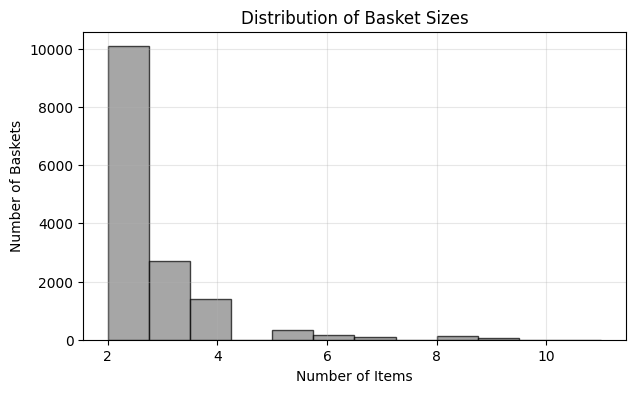

In [35]:
basket_sizes = df.groupby(['Member_number','Date'])['itemDescription'].apply(len)

print(f"Total transactions         : {basket_sizes.size}")
print(f"Average items per basket   : {basket_sizes.mean():.2f}")
print(f"Maximum items in a basket  : {basket_sizes.max()}\n")

plt.figure(figsize=(7,4))
plt.hist(basket_sizes, bins=12, color='gray', edgecolor='black', alpha=0.7)
plt.title("Distribution of Basket Sizes")
plt.xlabel("Number of Items")
plt.ylabel("Number of Baskets")
plt.grid(alpha=0.3)
plt.show()


In [36]:
transactions = df.groupby(['Member_number','Date'])['itemDescription'].apply(list)
print(f"Number of transactions to analyze: {len(transactions)}\n")

print("Sample transactions:")
for i, basket in enumerate(transactions.sample(3, random_state=42), 1):
    print(f"  Transaction {i}: {basket}")

Number of transactions to analyze: 14963

Sample transactions:
  Transaction 1: ['whole milk', 'rolls/buns']
  Transaction 2: ['root vegetables', 'nut snack']
  Transaction 3: ['frankfurter', 'whipped/sour cream', 'cat food']


In [37]:
te = TransactionEncoder()
onehot_array = te.fit_transform(transactions)
df_onehot = pd.DataFrame(onehot_array, columns=te.columns_)

min_support = 0.01
freq_itemsets = apriori(df_onehot, min_support=min_support, use_colnames=True)

print(f"\nFound {len(freq_itemsets)} frequent itemsets (support ≥ {min_support})")
print("Top 10 frequent itemsets:")
print(freq_itemsets.sort_values('support', ascending=False).head(10), "\n")


Found 69 frequent itemsets (support ≥ 0.01)
Top 10 frequent itemsets:
     support            itemsets
62  0.157923        (whole milk)
40  0.122101  (other vegetables)
46  0.110005        (rolls/buns)
52  0.097106              (soda)
63  0.085879            (yogurt)
47  0.069572   (root vegetables)
57  0.067767    (tropical fruit)
5   0.060683     (bottled water)
49  0.060349           (sausage)
15  0.053131      (citrus fruit) 



In [38]:
rules = association_rules(freq_itemsets, metric='lift', min_threshold=0.5)
print(f"Rules by lift ≥ 0.5: {len(rules)}")

if len(rules) < 10:
    print("Too few rules by lift, falling back to confidence ≥ 0.3")
    rules = association_rules(freq_itemsets, metric='confidence', min_threshold=0.3)
    print(f"Rules by confidence ≥ 0.3: {len(rules)}")

if 'lift' in rules.columns:
    top10 = rules.sort_values('lift', ascending=False).head(10)
else:
    top10 = rules.sort_values('confidence', ascending=False).head(10)

print("\nTop 10 rules:")
print(top10[['antecedents','consequents','support','confidence','lift']], "\n")

Rules by lift ≥ 0.5: 10

Top 10 rules:
          antecedents         consequents   support  confidence      lift
9        (whole milk)            (yogurt)  0.011161    0.070673  0.822940
8            (yogurt)        (whole milk)  0.011161    0.129961  0.822940
5        (whole milk)        (rolls/buns)  0.013968    0.088447  0.804028
4        (rolls/buns)        (whole milk)  0.013968    0.126974  0.804028
0  (other vegetables)        (rolls/buns)  0.010559    0.086481  0.786154
1        (rolls/buns)  (other vegetables)  0.010559    0.095990  0.786154
2  (other vegetables)        (whole milk)  0.014837    0.121511  0.769430
3        (whole milk)  (other vegetables)  0.014837    0.093948  0.769430
7        (whole milk)              (soda)  0.011629    0.073635  0.758296
6              (soda)        (whole milk)  0.011629    0.119752  0.758296 



In [31]:
print("Top 10 Recommendations:")
for idx, row in top10.iterrows():
    antecedent = ', '.join(row['antecedents'])
    consequent = ', '.join(row['consequents'])
    conf_pct = row['confidence'] * 100
    print(f"- If a customer buys [{antecedent}], recommend [{consequent}] — confidence {conf_pct:.1f}%")

Top 10 Recommendations:
- If a customer buys [whole milk], recommend [yogurt] — confidence 7.1%
- If a customer buys [yogurt], recommend [whole milk] — confidence 13.0%
- If a customer buys [whole milk], recommend [rolls/buns] — confidence 8.8%
- If a customer buys [rolls/buns], recommend [whole milk] — confidence 12.7%
- If a customer buys [other vegetables], recommend [rolls/buns] — confidence 8.6%
- If a customer buys [rolls/buns], recommend [other vegetables] — confidence 9.6%
- If a customer buys [other vegetables], recommend [whole milk] — confidence 12.2%
- If a customer buys [whole milk], recommend [other vegetables] — confidence 9.4%
- If a customer buys [whole milk], recommend [soda] — confidence 7.4%
- If a customer buys [soda], recommend [whole milk] — confidence 12.0%


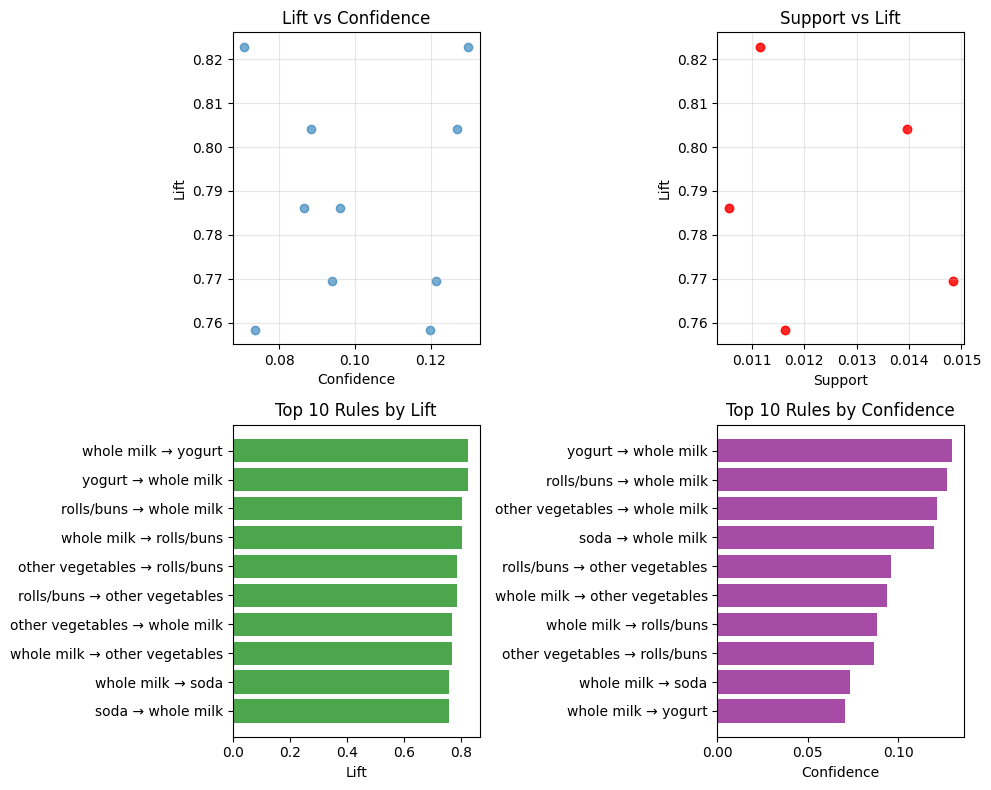

In [32]:
n = len(top10)
lift_sorted = top10.sort_values('lift', ascending=True)
conf_sorted = top10.sort_values('confidence', ascending=True)

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.scatter(rules['confidence'], rules['lift'], alpha=0.6)
plt.title("Lift vs Confidence")
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.grid(alpha=0.3)

plt.subplot(2,2,2)
plt.scatter(rules['support'], rules['lift'], alpha=0.6, color='red')
plt.title("Support vs Lift")
plt.xlabel("Support")
plt.ylabel("Lift")
plt.grid(alpha=0.3)

plt.subplot(2,2,3)
plt.barh(range(n), lift_sorted['lift'], color='green', alpha=0.7)
plt.yticks(range(n), [
    f"{', '.join(a)} → {', '.join(c)}"
    for a, c in zip(lift_sorted['antecedents'], lift_sorted['consequents'])
])
plt.title("Top 10 Rules by Lift")
plt.xlabel("Lift")

plt.subplot(2,2,4)
plt.barh(range(n), conf_sorted['confidence'], color='purple', alpha=0.7)
plt.yticks(range(n), [
    f"{', '.join(a)} → {', '.join(c)}"
    for a, c in zip(conf_sorted['antecedents'], conf_sorted['consequents'])
])
plt.title("Top 10 Rules by Confidence")
plt.xlabel("Confidence")

plt.tight_layout()
plt.show()